# Metody Inteligencji Obliczeniowej w Analizie Danych

[Tasks](https://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html)

### Lab 7: NN6: Zjawisko przeuczenia + regularyzacja (brak punktów za zadanie, sprawozdanie po tymtygodniu)

Zaimplementować mechanizm regularyzacji wag w sieci oraz mechanizm zatrzymywania uczenia przy wzroście błędu na zbiorze walidacyjnym.

Przeprowadzić eksperymenty na zbiorach i porównać skuteczność na zbiorze testowym dla różnych wariantów przeciwdziałania przeuczeniu sieci:
- multimodal-sparse,
- rings5-sparse,
- rings3-balance,
- xor3-balance.

## TODO:
- ~~implement regularization L1~~
- ~~implement regularization L2~~
- ~~add support for validation set~~ # done as already available test set parameter of the network
- ~~implement early stopping when validation error increases~~ # done as the increase on test set parameter of the network
- test L1 and L2 regularizations on all 4 datasets and compare results on test set

In [1]:
import MultiLayerPerceptron as mlp
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def plot_compare_predicted_real(net, x_train,y_train,x_test,y_test):
    xmin = min(x_train+ x_test)[0] *1.1
    xmax = max(x_train+ x_test)[0] *1.1

    fig1, ax = plt.subplots()

    ax.scatter(x_train, y_train, color="green",label="real y")
    ax.scatter(x_train, net.predict(x_train), color="red",label="predicted y")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.title("real vs predicted y - train data")
    ax.set_xlim(xmin, xmax)
    plt.show()

    fig1, ax = plt.subplots()
    ax.scatter(x_test, y_test, color="green",label="real y")
    ax.scatter(x_test, net.predict(x_test), color="red",label="predicted y")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.title("real vs predicted y - test data")
    plt.show()

def plot_good_vs_bad_predictions(network, x_test, y_test):
    pred_class = np.argmax(network.predict(x_test), axis=1)
    real_class = np.array(y_test).argmax(axis=1)
    is_good_prediction = real_class == pred_class
    
    fig, (axes_1, axes_2, axes_3) = plt.subplots(1, 3,figsize=(12, 4))
    sns.scatterplot(x=np.array(x_test)[:,0], y=np.array(x_test)[:,1], hue=real_class, ax=axes_1)
    axes_1.set_title("Real classes")
    sns.scatterplot(x=np.array(x_test)[:,0], y=np.array(x_test)[:,1], hue=pred_class, ax=axes_2)
    axes_2.set_title("Predicted classes")
    sns.scatterplot(x=np.array(x_test)[:,0], y=np.array(x_test)[:,1], hue=is_good_prediction, ax=axes_3)
    axes_3.set_title("Good vs Bad Predictions")
    plt.show()

def mse_on_test(net,x_test,y_test):
    return np.mean((np.array(y_test).flatten() - np.array(net.predict(x_test)).flatten())**2)

def f1_macro(net,x_test,y_test):
    return net._get_f1_macro(x_test,y_test)

## Dataset 1: multimodal-sparse

          x           y
0  1.833454  100.299995
1  0.030681  -19.499245
2  0.521312  -97.323986
3 -1.445119  100.251901
4 -0.034483   18.490846


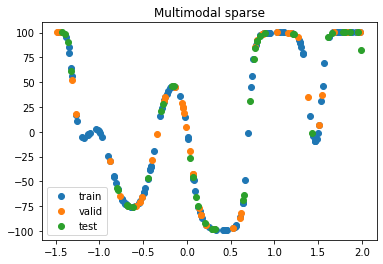

In [60]:
df_train = pd.read_csv('data/regression/multimodal-sparse-test.csv').sample(frac=1).reset_index(drop=True)
df_test = pd.read_csv('data/regression/multimodal-sparse-training.csv')
print(df_train.head())

x_train = [[x] for x in df_train.loc[:,"x"]]
y_train = [[y] for y in df_train.loc[:,"y"]]
x_test = [[x] for x in df_test.loc[:,"x"]]
y_test = [[y] for y in df_test.loc[:,"y"]]

x_valid = x_train[:int(len(x_train)/4)]
y_valid = y_train[:int(len(y_train)/4)]
x_train = x_train[int(len(x_train)/4):]
y_train = y_train[int(len(y_train)/4):]

plt.scatter(x_train, y_train, label="train")
plt.scatter(x_valid, y_valid, label="valid")
plt.scatter(x_test, y_test, label="test")
plt.title("Multimodal sparse")
plt.legend()
plt.show()

### Model 1 - L1

In [4]:
exponents = np.arange(1,16)
lambdas = 10 * 0.33 ** exponents
lambdas

array([3.30000000e+00, 1.08900000e+00, 3.59370000e-01, 1.18592100e-01,
       3.91353930e-02, 1.29146797e-02, 4.26184430e-03, 1.40640862e-03,
       4.64114844e-04, 1.53157899e-04, 5.05421065e-05, 1.66788951e-05,
       5.50403540e-06, 1.81633168e-06, 5.99389455e-07])

In [5]:
results = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(neurons_count=1, add_bias=True))
    net.add(mlp.Layer(neurons_count=100, activation_fun=mlp.ActivationTanh(), add_bias=True))
    net.add(mlp.Layer(neurons_count=1, add_bias=False))
    net.train(x_train, y_train, x_valid, y_valid, epochs=1000, learning_rate=0.001, batch_size=16, regularization=mlp.RegularizationL1(reg_param), stop_on_test_set_error_increase=True, quiet=True)
    results.append([reg_param,mse_on_test(net,x_test,y_test)])

reg_param:  3.3000000000000003
Early stopping: test error increased from 3756.24152 to 3756.59775
Epoch:  489/1000,  MSE loss train: 3035.149,  test: 3756.598
reg_param:  1.0890000000000002
Epoch: 1000/1000,  MSE loss train: 1753.851,  test: 2300.103
reg_param:  0.35937
Epoch: 1000/1000,  MSE loss train:  917.375,  test:  973.062
reg_param:  0.11859210000000002
Epoch: 1000/1000,  MSE loss train:  608.799,  test:  591.999
reg_param:  0.03913539300000001
Epoch: 1000/1000,  MSE loss train:  448.005,  test:  438.928
reg_param:  0.012914679690000003
Epoch: 1000/1000,  MSE loss train:  455.161,  test:  423.474
reg_param:  0.004261844297700002
Epoch: 1000/1000,  MSE loss train:  443.313,  test:  418.546
reg_param:  0.0014064086182410005
Epoch: 1000/1000,  MSE loss train:  427.814,  test:  401.517
reg_param:  0.00046411484401953016
Epoch: 1000/1000,  MSE loss train:  275.342,  test:   306.82
reg_param:  0.00015315789852644496
Epoch: 1000/1000,  MSE loss train:  434.578,  test:  400.227
reg_par

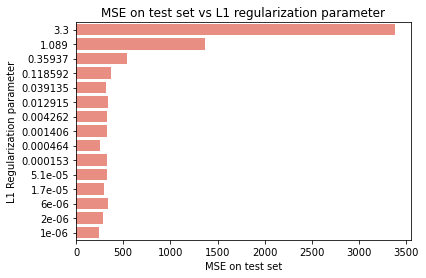

In [7]:
df = pd.DataFrame([[str(round(lamb,6)),mse_test] for (lamb,mse_test) in results], columns=["lambda", "mse_on_test"])
df.to_csv("lab7_result_1_1.csv")
ax = sns.barplot(data=df, y="lambda", x="mse_on_test", color="salmon")
ax.set_xlabel("MSE on test set")
ax.set_ylabel("L1 Regularization parameter")
ax.set_title("MSE on test set vs L1 regularization parameter")
plt.show()

### Model 2 - L2

In [8]:
results2 = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(neurons_count=1, add_bias=True))
    net.add(mlp.Layer(neurons_count=100, activation_fun=mlp.ActivationTanh(), add_bias=True))
    net.add(mlp.Layer(neurons_count=1, add_bias=False))
    net.train(x_train, y_train, x_valid, y_valid, epochs=1000, learning_rate=0.001, batch_size=16, regularization=mlp.RegularizationL2(reg_param), stop_on_test_set_error_increase=True, quiet=True)
    results2.append([reg_param,mse_on_test(net,x_test,y_test)])

reg_param:  3.3000000000000003
Early stopping: test error increased from 4659.85728 to 4660.20445
Epoch:   15/1000,  MSE loss train: 4490.067,  test: 4660.204
reg_param:  1.0890000000000002
Early stopping: test error increased from 3962.65322 to 3962.65327
Epoch:  558/1000,  MSE loss train: 3460.735,  test: 3962.653
reg_param:  0.35937
Epoch: 1000/1000,  MSE loss train:  2389.44,  test: 3133.528
reg_param:  0.11859210000000002
Epoch: 1000/1000,  MSE loss train: 1339.994,  test: 1625.807
reg_param:  0.03913539300000001
Epoch: 1000/1000,  MSE loss train:  812.561,  test:  864.749
reg_param:  0.012914679690000003
Epoch: 1000/1000,  MSE loss train:  532.694,  test:  522.329
reg_param:  0.004261844297700002
Epoch: 1000/1000,  MSE loss train:   396.67,  test:  417.328
reg_param:  0.0014064086182410005
Epoch: 1000/1000,  MSE loss train:  455.619,  test:  422.536
reg_param:  0.00046411484401953016
Epoch: 1000/1000,  MSE loss train:  278.342,  test:  304.772
reg_param:  0.00015315789852644496
E

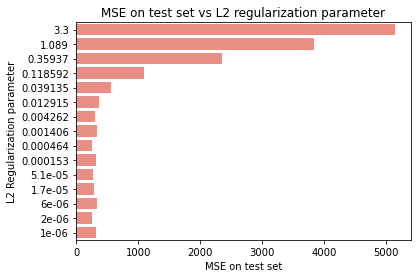

In [10]:
df2 = pd.DataFrame([[str(round(l,6)),mse_test] for (l,mse_test) in results2], columns=["lambda", "mse_on_test"])
ax = sns.barplot(data=df2, y="lambda", x="mse_on_test", color="salmon")
ax.set_xlabel("MSE on test set")
ax.set_ylabel("L2 Regularization parameter")
ax.set_title("MSE on test set vs L2 regularization parameter")
plt.show()

## Dataset 2: rings5-sparse

              x          y  c
1126 -60.874702  72.867810  4
344  -36.501683  65.181592  3
1218  73.154625 -36.964175  2
1396  66.740863   0.821087  2
820   12.154596 -66.620496  1

Unique classes: 5


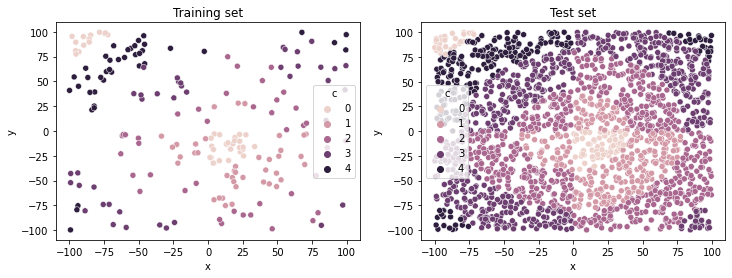

In [82]:
df_train = pd.read_csv('data/classification/rings5-sparse-training.csv').sample(frac=1)
df_test = pd.read_csv('data/classification/rings5-sparse-test.csv').sample(frac=1)
print(df_test.head())

# onehot encoding
x_train = df_train.loc[:,df_train.columns!='c'].to_numpy().tolist()
y_train = pd.get_dummies(df_train.loc[:,df_train.columns=='c'].squeeze(axis=1), prefix='class').to_numpy().tolist()
x_test = df_test.loc[:,df_test.columns!='c'].to_numpy().tolist()
y_test = pd.get_dummies(df_test.loc[:,df_test.columns=='c'].squeeze(axis=1), prefix='class').to_numpy().tolist()

print(f"\nUnique classes: {np.array(y_train).shape[1]}")

x_valid = x_train[:int(len(x_train)/10)]
y_valid = y_train[:int(len(y_train)/10)]
x_train = x_train[int(len(x_train)/10):]
y_train = y_train[int(len(y_train)/10):]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.scatterplot(data=df_train, x="x", y="y", hue="c", ax=ax1).set_title("Training set");
sns.scatterplot(data=df_test, x="x", y="y", hue="c", ax=ax2).set_title("Test set");
plt.show()

### Model 1 - L1

In [83]:
exponents = np.arange(1,16)
lambdas = 10 * 0.33 ** exponents

In [84]:
results = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(2))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(5, activation_fun=mlp.ActivationSoftmax(), add_bias=False))
    net.train(x_train, y_train, x_test, y_test, epochs=100, learning_rate=0.01,batch_size=10,\
        loss_function=mlp.LossCrossEntropy(), regularization=mlp.RegularizationL1(reg_param),\
            stop_on_test_set_error_increase=1.1, quiet=True)
    results.append([reg_param,f1_macro(net,x_test,y_test)])

reg_param:  3.3000000000000003


c:\Users\matem\PycharmProjects\miowad\MultiLayerPerceptron.py:308: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP+FP)


Epoch:  100/100,  CrossEntropy loss train:  102.214,  test:  102.191   |   F1 macro train:    0.067,  test:    0.102
reg_param:  1.0890000000000002
Epoch:  100/100,  CrossEntropy loss train:   30.491,  test:   30.472   |   F1 macro train:    0.067,  test:    0.102
reg_param:  0.35937
Epoch:  100/100,  CrossEntropy loss train:   22.999,  test:   22.996   |   F1 macro train:    0.067,  test:    0.102
reg_param:  0.11859210000000002
Epoch:  100/100,  CrossEntropy loss train:   22.206,  test:   22.203   |   F1 macro train:    0.068,  test:    0.053
reg_param:  0.03913539300000001
Epoch:  100/100,  CrossEntropy loss train:   18.577,  test:   18.729   |   F1 macro train:    0.425,  test:    0.379
reg_param:  0.012914679690000003
Epoch:  100/100,  CrossEntropy loss train:   16.723,  test:   17.692   |   F1 macro train:    0.645,  test:    0.522
reg_param:  0.004261844297700002
Epoch:  100/100,  CrossEntropy loss train:   15.457,  test:   17.125   |   F1 macro train:    0.672,  test:    0.504


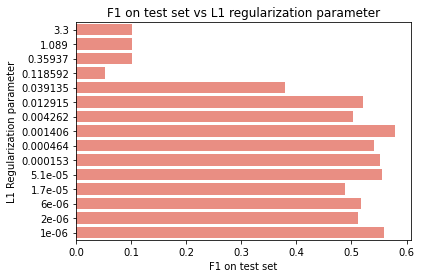

In [85]:
df2 = pd.DataFrame([[str(round(l,6)),f1] for (l,f1) in results], columns=["lambda", "f1_macro_on_test"])
ax = sns.barplot(data=df2, y="lambda", x="f1_macro_on_test", color="salmon")
ax.set_xlabel("F1 on test set")
ax.set_ylabel("L1 Regularization parameter")
ax.set_title("F1 on test set vs L1 regularization parameter")
plt.show()

Best F1 macro 
- train: 0.713,  
- validation: 0.748,
- test: around 0.5

Highest F1 macro on test was achieved with early stopping turned off and was around 0.65 and is not presented here.

### Model 2 - L2

In [86]:
results2 = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(2))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(5, activation_fun=mlp.ActivationSoftmax(), add_bias=False))
    net.train(x_train, y_train, x_test, y_test, epochs=100, learning_rate=0.01,batch_size=10,\
        loss_function=mlp.LossCrossEntropy(), regularization=mlp.RegularizationL2(reg_param),\
            stop_on_test_set_error_increase=1.1, quiet=True)
    results2.append([reg_param,f1_macro(net,x_test,y_test)])

reg_param:  3.3000000000000003


c:\Users\matem\PycharmProjects\miowad\MultiLayerPerceptron.py:308: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP+FP)


Epoch:  100/100,  CrossEntropy loss train:   22.105,  test:   22.102   |   F1 macro train:    0.067,  test:    0.102
reg_param:  1.0890000000000002
Epoch:  100/100,  CrossEntropy loss train:   22.105,  test:   22.101   |   F1 macro train:    0.068,  test:    0.042
reg_param:  0.35937
Epoch:  100/100,  CrossEntropy loss train:   22.104,  test:   22.098   |   F1 macro train:    0.068,  test:    0.042
reg_param:  0.11859210000000002
Epoch:  100/100,  CrossEntropy loss train:    19.96,  test:   20.159   |   F1 macro train:    0.362,  test:    0.339
reg_param:  0.03913539300000001
Epoch:  100/100,  CrossEntropy loss train:   17.209,  test:    17.92   |   F1 macro train:    0.483,  test:    0.432
reg_param:  0.012914679690000003
Epoch:  100/100,  CrossEntropy loss train:   14.969,  test:   16.841   |   F1 macro train:     0.68,  test:    0.522
reg_param:  0.004261844297700002
Epoch:  100/100,  CrossEntropy loss train:   13.632,  test:   15.381   |   F1 macro train:    0.695,  test:    0.568


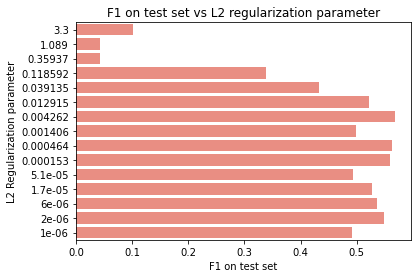

In [87]:
df2 = pd.DataFrame([[str(round(l,6)),f1] for (l,f1) in results2], columns=["lambda", "f1_macro_on_test"])
ax = sns.barplot(data=df2, y="lambda", x="f1_macro_on_test", color="salmon")
ax.set_xlabel("F1 on test set")
ax.set_ylabel("L2 Regularization parameter")
ax.set_title("F1 on test set vs L2 regularization parameter")
plt.show()

Best F1 macro
- train: 0.715,  
- validation: 0.694,
- test: around 0.5.

Highest F1 macro on test was achieved with early stopping turned off and was around 0.65 and is not presented here.


## Dataset 3: rings3-balance

Train set not balanced - barely any points from the class 2. It's hard not to skip these points which results in low f1 macro score (macro = average of f1 scores for each class). Score around 0.66 means that f1 for class 2 is around 0 and the rest is perfect. Since results here are exactly around this value or even lower - that's exactly what happened.

              x          y  c
848   48.556022  53.723381  1
298  -66.244220 -80.480830  0
1351  -0.940064  64.435315  2
1342  -5.395668  -7.046729  1
1617 -37.585223  25.898441  1

Unique classes: 3


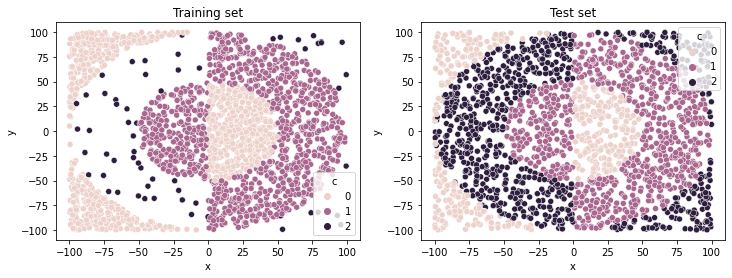

In [53]:
df_train = pd.read_csv('data/classification/rings3-balance-training.csv').sample(frac=1)
df_test = pd.read_csv('data/classification/rings3-balance-test.csv').sample(frac=1)
print(df_test.head())

# onehot encoding
x_train = df_train.loc[:,df_train.columns!='c'].to_numpy().tolist()
y_train = pd.get_dummies(df_train.loc[:,df_train.columns=='c'].squeeze(axis=1), prefix='class').to_numpy().tolist()
x_test = df_test.loc[:,df_test.columns!='c'].to_numpy().tolist()
y_test = pd.get_dummies(df_test.loc[:,df_test.columns=='c'].squeeze(axis=1), prefix='class').to_numpy().tolist()

print(f"\nUnique classes: {np.array(y_train).shape[1]}")

x_valid = x_train[:int(len(x_train)/10)]
y_valid = y_train[:int(len(y_train)/10)]
x_train = x_train[int(len(x_train)/10):]
y_train = y_train[int(len(y_train)/10):]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.scatterplot(data=df_train, x="x", y="y", hue="c", ax=ax1).set_title("Training set");
sns.scatterplot(data=df_test, x="x", y="y", hue="c", ax=ax2).set_title("Test set");
plt.show()

### Model 1 - L1

In [39]:
exponents = np.arange(1,16)
lambdas = 10 * 0.33 ** exponents

In [41]:
results = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(neurons_count=1, add_bias=True))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(neurons_count=3,activation_fun=mlp.ActivationTanh(), add_bias=False))
    net.train(x_train, y_train, x_valid, y_valid, epochs=100, learning_rate=0.03, batch_size=20, loss_function=mlp.LossMSE(f1_score=True),\
        regularization=mlp.RegularizationL1(reg_param), stop_on_test_set_error_increase=1.1, quiet=True)
    results.append([reg_param,f1_macro(net,x_test,y_test)])

reg_param:  3.3000000000000003


c:\Users\matem\PycharmProjects\miowad\MultiLayerPerceptron.py:308: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP+FP)


Early stopping: test error increased from 145.71121 to 161.96713
Epoch:   66/100,  MSE loss train:  161.967,  test:  161.967   |   F1 macro train:    0.212,  test:    0.207
reg_param:  1.0890000000000002
Epoch:  100/100,  MSE loss train:   17.271,  test:   17.271   |   F1 macro train:    0.019,  test:    0.019
reg_param:  0.35937
Epoch:  100/100,  MSE loss train:    2.214,  test:    2.214   |   F1 macro train:    0.218,  test:    0.213
reg_param:  0.11859210000000002
Epoch:  100/100,  MSE loss train:    0.471,  test:    0.471   |   F1 macro train:    0.218,  test:    0.213
reg_param:  0.03913539300000001
Epoch:  100/100,  MSE loss train:    0.253,  test:    0.256   |   F1 macro train:    0.455,  test:    0.439
reg_param:  0.012914679690000003
Epoch:  100/100,  MSE loss train:    0.184,  test:     0.18   |   F1 macro train:    0.526,  test:    0.554
reg_param:  0.004261844297700002
Epoch:  100/100,  MSE loss train:    0.122,  test:     0.12   |   F1 macro train:    0.633,  test:    0.63

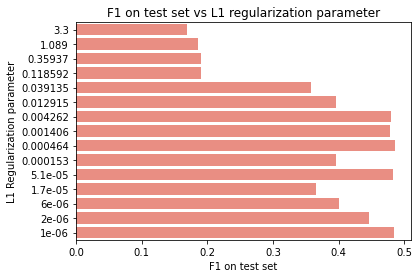

In [42]:
df = pd.DataFrame([[str(round(l,6)),f1] for (l,f1) in results], columns=["lambda", "f1_macro_on_test"])
ax = sns.barplot(data=df, y="lambda", x="f1_macro_on_test", color="salmon")
ax.set_xlabel("F1 on test set")
ax.set_ylabel("L1 Regularization parameter")
ax.set_title("F1 on test set vs L1 regularization parameter")
plt.show()

### Model 2 - L2

In [43]:
results2 = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(neurons_count=1, add_bias=True))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(neurons_count=3,activation_fun=mlp.ActivationTanh(), add_bias=False))
    net.train(x_train, y_train, x_valid, y_valid, epochs=100, learning_rate=0.03, batch_size=20, loss_function=mlp.LossMSE(f1_score=True),\
        regularization=mlp.RegularizationL2(reg_param), stop_on_test_set_error_increase=1.1, quiet=True)
    results2.append([reg_param,f1_macro(net,x_test,y_test)])

reg_param:  3.3000000000000003


c:\Users\matem\PycharmProjects\miowad\MultiLayerPerceptron.py:308: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP+FP)


Epoch:  100/100,  MSE loss train:    0.322,  test:    0.322   |   F1 macro train:    0.218,  test:    0.213
reg_param:  1.0890000000000002
Epoch:  100/100,  MSE loss train:    0.301,  test:    0.301   |   F1 macro train:    0.218,  test:    0.213
reg_param:  0.35937
Epoch:  100/100,  MSE loss train:    0.262,  test:    0.262   |   F1 macro train:    0.218,  test:    0.213
reg_param:  0.11859210000000002
Epoch:  100/100,  MSE loss train:    0.242,  test:    0.241   |   F1 macro train:    0.419,  test:     0.42
reg_param:  0.03913539300000001
Epoch:  100/100,  MSE loss train:    0.174,  test:    0.172   |   F1 macro train:    0.457,  test:    0.463
reg_param:  0.012914679690000003
Epoch:  100/100,  MSE loss train:    0.134,  test:    0.131   |   F1 macro train:    0.633,  test:     0.65
reg_param:  0.004261844297700002
Epoch:  100/100,  MSE loss train:     0.17,  test:    0.168   |   F1 macro train:    0.451,  test:    0.452
reg_param:  0.0014064086182410005
Epoch:  100/100,  MSE loss tr

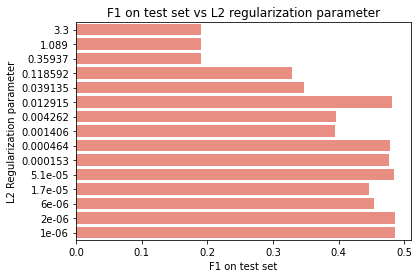

In [44]:
df2 = pd.DataFrame([[str(round(l,6)),f1] for (l,f1) in results2], columns=["lambda", "f1_macro_on_test"])
ax = sns.barplot(data=df2, y="lambda", x="f1_macro_on_test", color="salmon")
ax.set_xlabel("F1 on test set")
ax.set_ylabel("L2 Regularization parameter")
ax.set_title("F1 on test set vs L2 regularization parameter")
plt.show()

## Dataset 4: xor3-balance

             x          y  c
82   96.305948  11.420073  1
258 -96.688637  -1.058662  1
506 -33.704509 -95.467827  0
178  67.732782  72.405851  0
301  46.346694  87.581868  0

Unique classes: 2


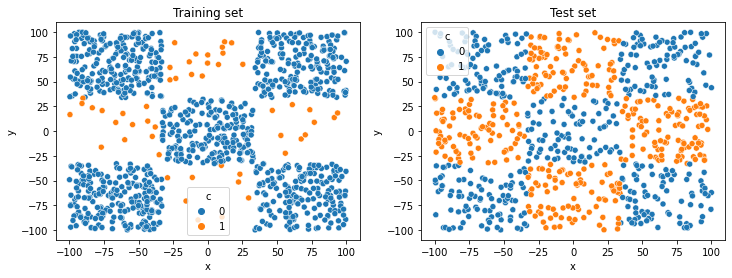

In [88]:
df_train = pd.read_csv('data/classification/xor3-balance-training.csv').sample(frac=1)
df_test = pd.read_csv('data/classification/xor3-balance-test.csv').sample(frac=1)
print(df_test.head())

# onehot encoding
x_train = df_train.loc[:,df_train.columns!='c'].to_numpy().tolist()
y_train = pd.get_dummies(df_train.loc[:,df_train.columns=='c'].squeeze(axis=1), prefix='class').to_numpy().tolist()
x_test = df_test.loc[:,df_test.columns!='c'].to_numpy().tolist()
y_test = pd.get_dummies(df_test.loc[:,df_test.columns=='c'].squeeze(axis=1), prefix='class').to_numpy().tolist()

print(f"\nUnique classes: {np.array(y_train).shape[1]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.scatterplot(data=df_train, x="x", y="y", hue="c", ax=ax1).set_title("Training set");
sns.scatterplot(data=df_test, x="x", y="y", hue="c", ax=ax2).set_title("Test set");
plt.show()

### Model 1 - L1

In [89]:
exponents = np.arange(1,16)
lambdas = 10 * 0.33 ** exponents

In [90]:
results2 = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(2))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(2, activation_fun=mlp.ActivationSoftmax(), add_bias=False))
    net.train(x_train, y_train, x_test, y_test, epochs=100, learning_rate=0.03,batch_size=50,\
        loss_function=mlp.LossCrossEntropy(), stop_on_test_set_error_increase=1.1, quiet=True,\
            regularization=mlp.RegularizationL1(reg_param))
    results2.append([reg_param,f1_macro(net,x_test,y_test)])

reg_param:  3.3000000000000003


c:\Users\matem\PycharmProjects\miowad\MultiLayerPerceptron.py:308: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP+FP)


Epoch:  100/100,  CrossEntropy loss train:  242.296,  test:  242.656   |   F1 macro train:    0.488,  test:    0.356
reg_param:  1.0890000000000002
Epoch:  100/100,  CrossEntropy loss train:   36.833,  test:   37.186   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.35937
Epoch:  100/100,  CrossEntropy loss train:   14.275,  test:   16.328   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.11859210000000002
Epoch:  100/100,  CrossEntropy loss train:    5.945,  test:    13.32   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.03913539300000001
Epoch:  100/100,  CrossEntropy loss train:    3.494,  test:   12.339   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.012914679690000003
Epoch:  100/100,  CrossEntropy loss train:    2.448,  test:   11.058   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.004261844297700002
Epoch:  100/100,  CrossEntropy loss train:    1.991,  test:    8.814   |   F1 macro train:      0.8,  test:     0.65


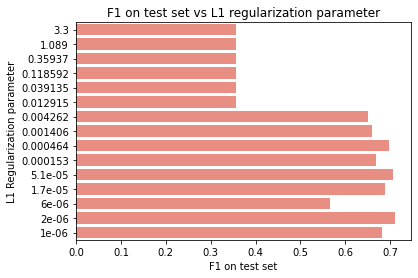

In [91]:
df2 = pd.DataFrame([[str(round(l,6)),f1] for (l,f1) in results2], columns=["lambda", "f1_macro_on_test"])
ax = sns.barplot(data=df2, y="lambda", x="f1_macro_on_test", color="salmon")
ax.set_xlabel("F1 on test set")
ax.set_ylabel("L1 Regularization parameter")
ax.set_title("F1 on test set vs L1 regularization parameter")
plt.show()

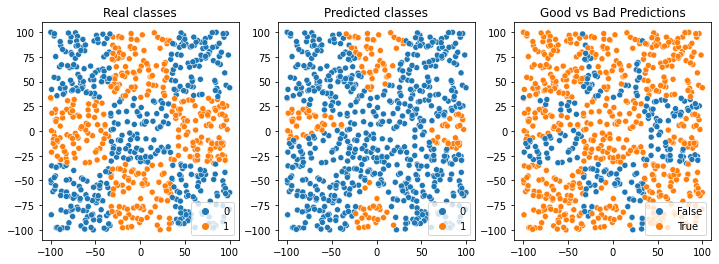

In [92]:
plot_good_vs_bad_predictions(net, x_test, y_test)

### Model 2 - L2

In [93]:
results2 = []
for reg_param in lambdas:
    print("reg_param: ", reg_param)
    net = mlp.NeuralNetwork()
    net.add(mlp.Layer(2))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(20, activation_fun=mlp.ActivationReLU()))
    net.add(mlp.Layer(2, activation_fun=mlp.ActivationSoftmax(), add_bias=False))
    net.train(x_train, y_train, x_test, y_test, epochs=100, learning_rate=0.03,batch_size=50,\
        loss_function=mlp.LossCrossEntropy(), stop_on_test_set_error_increase=1.1, quiet=True,\
            regularization=mlp.RegularizationL2(reg_param))
    results2.append([reg_param,f1_macro(net,x_test,y_test)])

reg_param:  3.3000000000000003


c:\Users\matem\PycharmProjects\miowad\MultiLayerPerceptron.py:308: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP+FP)


Epoch:  100/100,  CrossEntropy loss train:   13.049,  test:    13.75   |   F1 macro train:    0.488,  test:    0.356
reg_param:  1.0890000000000002
Epoch:  100/100,  CrossEntropy loss train:   11.784,  test:   13.635   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.35937
Epoch:  100/100,  CrossEntropy loss train:    9.406,  test:   13.395   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.11859210000000002
Epoch:  100/100,  CrossEntropy loss train:    3.944,  test:   12.533   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.03913539300000001
Epoch:  100/100,  CrossEntropy loss train:    3.066,  test:   12.427   |   F1 macro train:    0.488,  test:    0.356
reg_param:  0.012914679690000003
Epoch:  100/100,  CrossEntropy loss train:    1.974,  test:    9.118   |   F1 macro train:      0.8,  test:    0.591
reg_param:  0.004261844297700002
Epoch:  100/100,  CrossEntropy loss train:    1.605,  test:    8.123   |   F1 macro train:    0.839,  test:    0.672


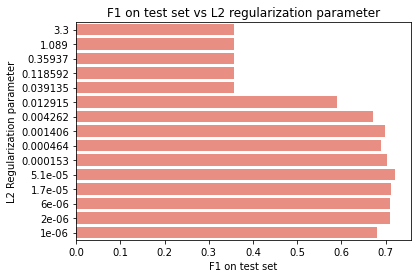

In [94]:
df2 = pd.DataFrame([[str(round(l,6)),f1] for (l,f1) in results2], columns=["lambda", "f1_macro_on_test"])
ax = sns.barplot(data=df2, y="lambda", x="f1_macro_on_test", color="salmon")
ax.set_xlabel("F1 on test set")
ax.set_ylabel("L2 Regularization parameter")
ax.set_title("F1 on test set vs L2 regularization parameter")
plt.show()

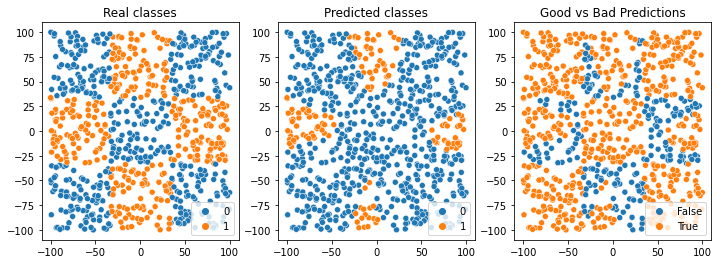

In [95]:
plot_good_vs_bad_predictions(net, x_test, y_test)

# Summary